In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.4 MB/s eta 0:00:00


In [ ]:
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)



!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

HOME: /content
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch

# Paths
INPUT_FOLDER = "input_images"  # Folder containing input images (P1_pre.jpg, P1_post.jpg, etc.)
OUTPUT_FOLDER = "output_results"  # Folder to save results
CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to preprocess images using rembg
def remove_background(image_path):
    with open(image_path, "rb") as img_file:
        image_data = img_file.read()
    processed_image = remove(image_data)
    return cv2.imdecode(np.frombuffer(processed_image, np.uint8), cv2.IMREAD_COLOR)

# Function to apply SAM and generate segmentation mask
def segment_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    mask = np.zeros_like(image_rgb[:, :, 0])
    for item in sam_result:
        mask = np.maximum(mask, item["segmentation"].astype(np.uint8))
    return mask

# Function to compute damage mask
def calculate_damage_mask(pre_mask, post_mask):
    return (post_mask - pre_mask).clip(0, 1)

# Process each pair of images
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

image_pairs = [(f, f.replace("_pre", "_post")) for f in os.listdir(INPUT_FOLDER) if "_pre" in f]
for pre_name, post_name in image_pairs:
    pre_path = os.path.join(INPUT_FOLDER, pre_name)
    post_path = os.path.join(INPUT_FOLDER, post_name)

    # Remove background
    pre_image = remove_background(pre_path)
    post_image = remove_background(post_path)

    # Segment images using SAM
    pre_mask = segment_image(pre_image)
    post_mask = segment_image(post_image)

    # Compute damage mask
    damage_mask = calculate_damage_mask(pre_mask, post_mask)

    # Create damage overlay
    post_overlay = post_image.copy()
    post_overlay[damage_mask == 1] = [0, 0, 255]  # Highlight damages in red

    # Save results
    pair_folder = os.path.join(OUTPUT_FOLDER, pre_name.split("_pre")[0])
    if not os.path.exists(pair_folder):
        os.makedirs(pair_folder)

    cv2.imwrite(os.path.join(pair_folder, "segmented_pre.png"), pre_mask * 255)
    cv2.imwrite(os.path.join(pair_folder, "segmented_post.png"), post_mask * 255)
    cv2.imwrite(os.path.join(pair_folder, "damage_mask.png"), (damage_mask * 255).astype(np.uint8))

    # Display results (optional)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Pre-Damage Segmented")
    plt.imshow(pre_mask, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Post-Damage Segmented")
    plt.imshow(post_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Damage Mask Overlay")
    plt.imshow(cv2.cvtColor(post_overlay, cv2.COLOR_BGR2RGB))
    plt.show()

print(f"Processing complete. Results saved in {OUTPUT_FOLDER}.")


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import supervision as sv

# Paths
INPUT_FOLDER = "input_images"  # Folder containing input images (P1_pre.jpg, P1_post.jpg, etc.)
OUTPUT_FOLDER = "output_results"  # Folder to save results
CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"

# Load SAM model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to preprocess images using rembg
def remove_background(image_path):
    with open(image_path, "rb") as img_file:
        image_data = img_file.read()
    processed_image = remove(image_data)
    return cv2.imdecode(np.frombuffer(processed_image, np.uint8), cv2.IMREAD_COLOR)

# Function to apply SAM and generate segmentation mask
def segment_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    detections = sv.Detections.from_sam(sam_result=sam_result)
    return detections

# Function to compute damage mask
def calculate_damage_mask(pre_mask, post_mask):
    return (post_mask - pre_mask).clip(0, 1)

# Process each pair of images
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

image_pairs = [(f, f.replace("_pre", "_post")) for f in os.listdir(INPUT_FOLDER) if "_pre" in f]
for pre_name, post_name in image_pairs:
    pre_path = os.path.join(INPUT_FOLDER, pre_name)
    post_path = os.path.join(INPUT_FOLDER, post_name)

    # Remove background
    pre_image = remove_background(pre_path)
    post_image = remove_background(post_path)

    # Segment images using SAM
    pre_detections = segment_image(pre_image)
    post_detections = segment_image(post_image)

    # Generate annotated masks using supervision
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    pre_annotated = mask_annotator.annotate(scene=pre_image.copy(), detections=pre_detections)
    post_annotated = mask_annotator.annotate(scene=post_image.copy(), detections=post_detections)

    # Create binary masks
    pre_mask = pre_detections.to_mask()
    post_mask = post_detections.to_mask()

    # Compute damage mask
    damage_mask = calculate_damage_mask(pre_mask, post_mask)

    # Create damage overlay
    post_overlay = post_image.copy()
    post_overlay[damage_mask == 1] = [0, 0, 255]  # Highlight damages in red

    # Save results
    pair_folder = os.path.join(OUTPUT_FOLDER, pre_name.split("_pre")[0])
    if not os.path.exists(pair_folder):
        os.makedirs(pair_folder)

    cv2.imwrite(os.path.join(pair_folder, "segmented_pre.png"), pre_annotated)
    cv2.imwrite(os.path.join(pair_folder, "segmented_post.png"), post_annotated)
    cv2.imwrite(os.path.join(pair_folder, "damage_mask.png"), (damage_mask * 255).astype(np.uint8))

    # Display results (optional)
    sv.plot_images_grid(
        images=[pre_annotated, post_annotated, post_overlay],
        grid_size=(1, 3),
        titles=["Pre-Damage Segmented", "Post-Damage Segmented", "Damage Mask Overlay"]
    )

print(f"Processing complete. Results saved in {OUTPUT_FOLDER}.")


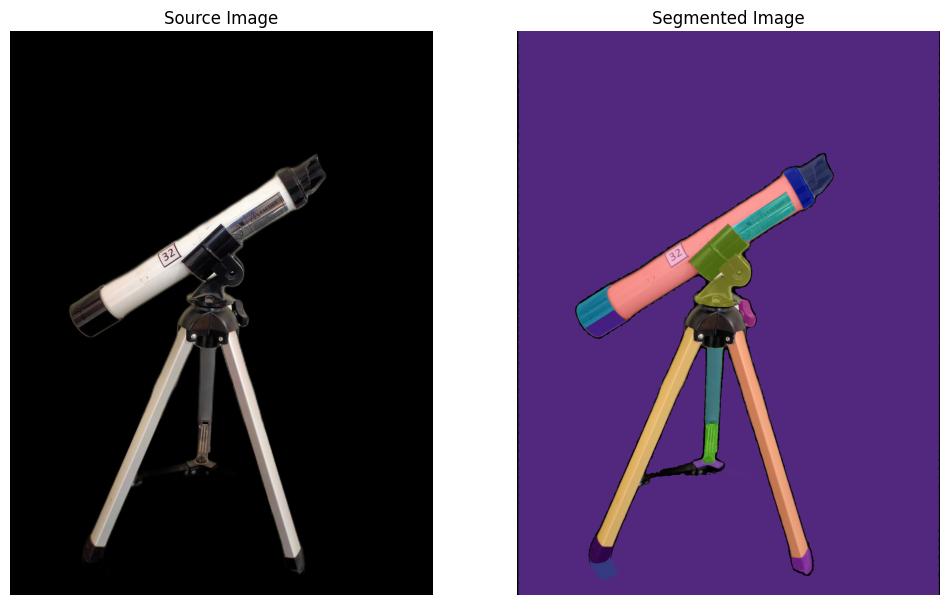

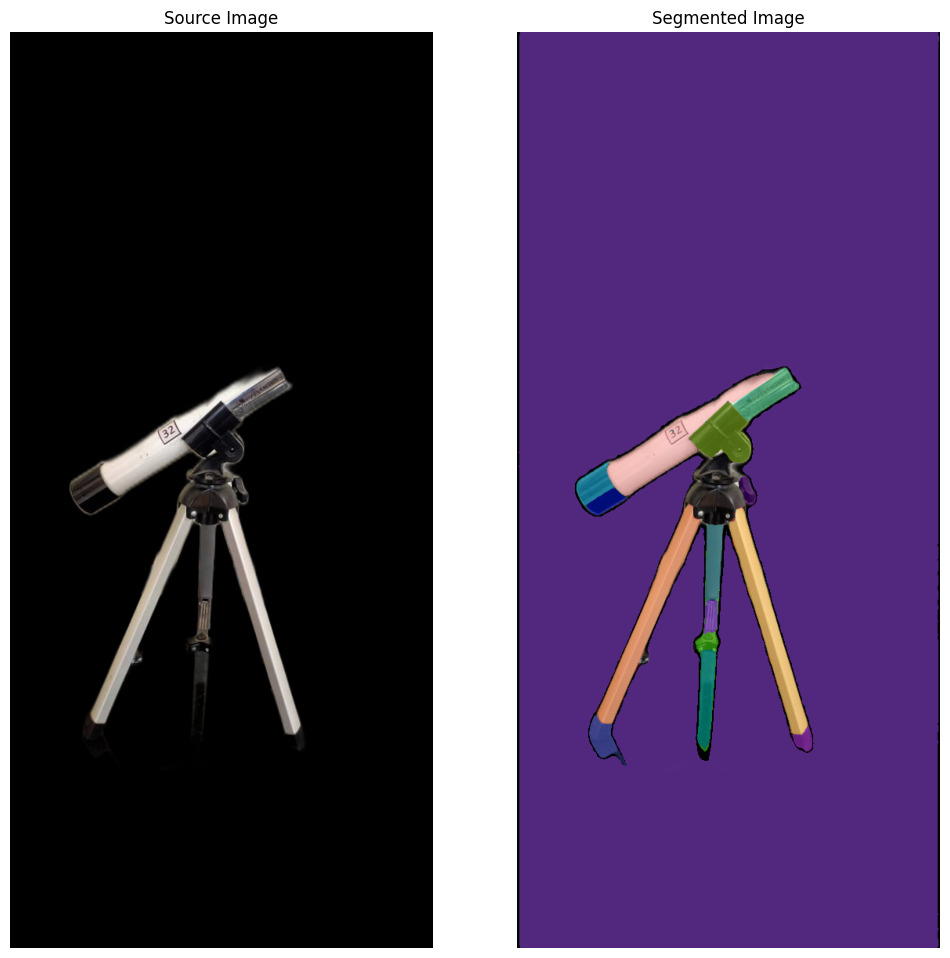

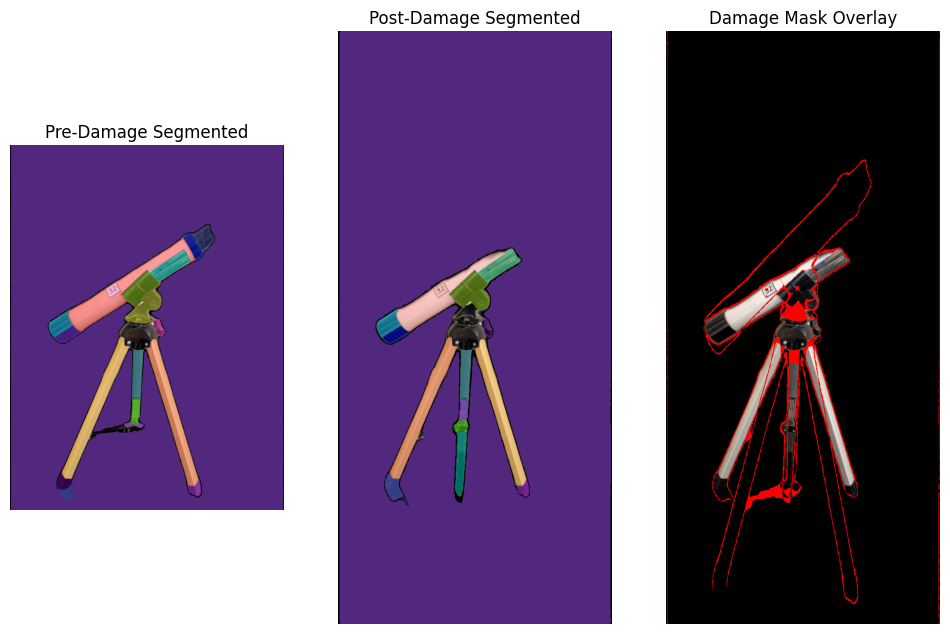

Processing complete. Results saved in output_results.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import supervision as sv

# Paths
INPUT_FOLDER = "input_images"  # Folder containing input images (P1_pre.jpg, P1_post.jpg, etc.)
OUTPUT_FOLDER = "output_results"  # Folder to save results
CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"

# Load SAM model and initialize the mask generator
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to remove the background using rembg
def remove_background(image_path):
    with open(image_path, "rb") as img_file:
        image_data = img_file.read()
    processed_image = remove(image_data)
    return cv2.imdecode(np.frombuffer(processed_image, np.uint8), cv2.IMREAD_COLOR)

# Function to segment an image using SAM and annotate it
def segment_image(image_bgr, mask_generator):
    """
    Segments an input image using SAM and visualizes the result with supervision.

    Args:
        image_bgr (np.ndarray): Input image in BGR format.
        mask_generator (SamAutomaticMaskGenerator): Initialized SAM mask generator.

    Returns:
        tuple: (annotated_image, binary_mask) where:
            - annotated_image (np.ndarray): Image with segmentation annotations.
            - binary_mask (np.ndarray): Binary segmentation mask.
    """
    # Convert the input BGR image to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Generate masks using SAM
    sam_result = mask_generator.generate(image_rgb)

    # Convert SAM result to Detections format for supervision
    detections = sv.Detections.from_sam(sam_result=sam_result)

    # Annotate the scene using supervision's MaskAnnotator
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Create a single binary mask from all the SAM segmentations
    binary_mask = sum(item["segmentation"].astype(np.uint8) for item in sam_result).clip(0, 1)

    # Display the source and annotated images (Optional for debugging)
    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=["Source Image", "Segmented Image"]
    )

    return annotated_image, binary_mask

# Function to calculate the damage mask

def calculate_damage_mask(pre_mask, post_mask):
    # Resize pre_mask to match post_mask's shape
    pre_mask_resized = cv2.resize(pre_mask.astype(np.uint8), (post_mask.shape[1], post_mask.shape[0]))

    # Convert back to boolean for consistency
    pre_mask_resized = pre_mask_resized.astype(bool)

    # Now perform the subtraction
    return (post_mask - pre_mask_resized).clip(0, 1)
# Process each pair of images
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

image_pairs = [(f, f.replace("_pre", "_post")) for f in os.listdir(INPUT_FOLDER) if "_pre" in f]
for pre_name, post_name in image_pairs:
    pre_path = os.path.join(INPUT_FOLDER, pre_name)
    post_path = os.path.join(INPUT_FOLDER, post_name)

    # Remove background
    pre_image = remove_background(pre_path)
    post_image = remove_background(post_path)

    # Segment images using SAM
    pre_annotated, pre_mask = segment_image(pre_image, mask_generator)
    post_annotated, post_mask = segment_image(post_image, mask_generator)

    # Compute damage mask
    damage_mask = calculate_damage_mask(pre_mask, post_mask)

    # Create damage overlay
    post_overlay = post_image.copy()
    post_overlay[damage_mask == 1] = [0, 0, 255]  # Highlight damages in red

    # Save results
    pair_folder = os.path.join(OUTPUT_FOLDER, pre_name.split("_pre")[0])
    if not os.path.exists(pair_folder):
        os.makedirs(pair_folder)

    cv2.imwrite(os.path.join(pair_folder, "segmented_pre.png"), pre_annotated)
    cv2.imwrite(os.path.join(pair_folder, "segmented_post.png"), post_annotated)
    cv2.imwrite(os.path.join(pair_folder, "damage_mask.png"), (damage_mask * 255).astype(np.uint8))

    # Display results (optional)
    sv.plot_images_grid(
        images=[pre_annotated, post_annotated, post_overlay],
        grid_size=(1, 3),
        titles=["Pre-Damage Segmented", "Post-Damage Segmented", "Damage Mask Overlay"]
    )

print(f"Processing complete. Results saved in {OUTPUT_FOLDER}.")


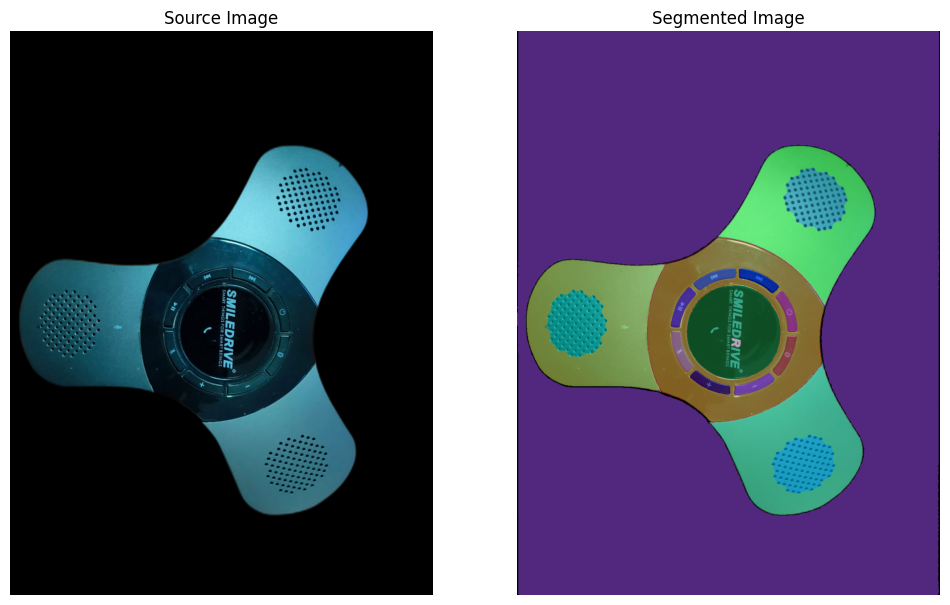

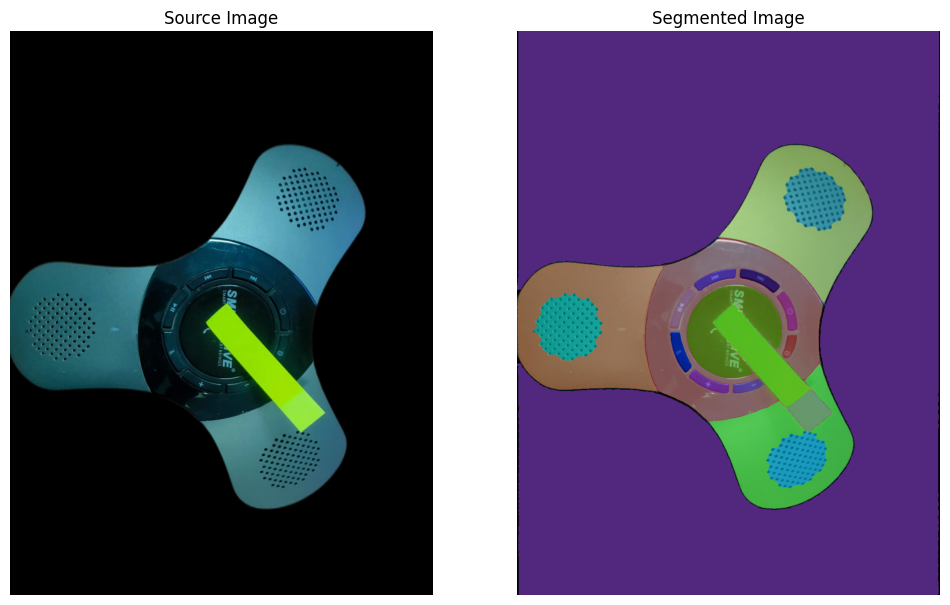

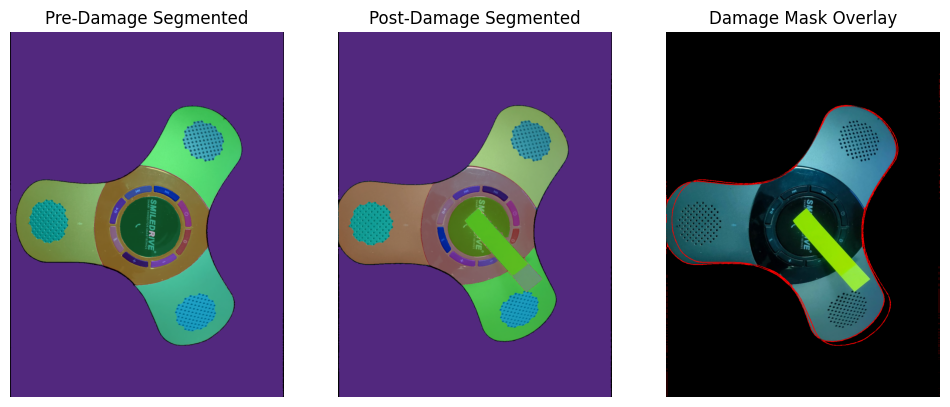

Processing complete. Results saved in output_results.


In [ ]:
# Process each pair of images
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

image_pairs = [(f, f.replace("_pre", "_post")) for f in os.listdir(INPUT_FOLDER) if "_pre" in f]
for pre_name, post_name in image_pairs:
    pre_path = os.path.join(INPUT_FOLDER, pre_name)
    post_path = os.path.join(INPUT_FOLDER, post_name)

    # Remove background
    pre_image = remove_background(pre_path)
    post_image = remove_background(post_path)

    # Segment images using SAM
    pre_annotated, pre_mask = segment_image(pre_image, mask_generator)
    post_annotated, post_mask = segment_image(post_image, mask_generator)

    # Compute damage mask
    damage_mask = calculate_damage_mask(pre_mask, post_mask)

    # Create damage overlay
    post_overlay = post_image.copy()
    post_overlay[damage_mask == 1] = [0, 0, 255]  # Highlight damages in red

    # Save results
    pair_folder = os.path.join(OUTPUT_FOLDER, pre_name.split("_pre")[0])
    if not os.path.exists(pair_folder):
        os.makedirs(pair_folder)

    cv2.imwrite(os.path.join(pair_folder, "segmented_pre.png"), pre_annotated)
    cv2.imwrite(os.path.join(pair_folder, "segmented_post.png"), post_annotated)
    cv2.imwrite(os.path.join(pair_folder, "damage_mask.png"), (damage_mask * 255).astype(np.uint8))

    # Display results (optional)
    sv.plot_images_grid(
        images=[pre_annotated, post_annotated, post_overlay],
        grid_size=(1, 3),
        titles=["Pre-Damage Segmented", "Post-Damage Segmented", "Damage Mask Overlay"]
    )

print(f"Processing complete. Results saved in {OUTPUT_FOLDER}.")